مكونات بيانات STAC

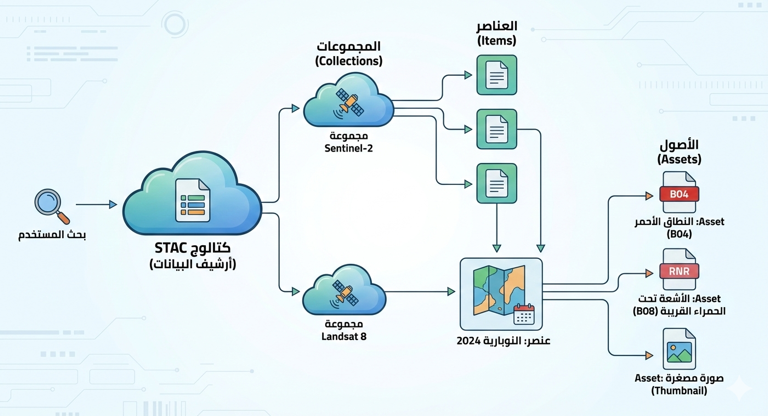

In [ ]:
# Install libraries
!pip install -q pystac-client odc-stac rioxarray netCDF4

In [ ]:
# Import necessary libraries

from pystac_client import Client
from odc.stac import load as odc_load

import pandas as pd
import geopandas as gpd
import rioxarray  as rxr
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import netCDF4
import warnings
import os

# Configure Xarray for better display and performance
xr.set_options(keep_attrs=True, display_expand_data=False)
# Configure NumPy display for cleaner output
np.set_printoptions(threshold=10, edgeitems=2)
# Configure matplotlib for better plots
plt.rcParams["figure.dpi"] = 150

warnings.filterwarnings("ignore");


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Define your save folder directory
GEE_Exports= '/content/drive/MyDrive/GEE_Exports'

# Create the directory if it doesn't exist
if not os.path.exists(GEE_Exports):
    os.makedirs(GEE_Exports)
    print(f"Created new directory: {GEE_Exports}")
else:
    print(f"Directory already exists: {GEE_Exports}")

In [ ]:
# Load AOI from GeoJSON:

# file Inputs
geojson_file = '/content/drive/MyDrive/Nour_projects_2026/STAC_NDVI/aoi.geojson'

# Load the AOI GeoJSON file into a GeoDataFrame
aoi_gdf = gpd.read_file(geojson_file)

# Ensure EPSG:4326 for STAC Search
if aoi_gdf.crs != "EPSG:4326":
    aoi_gdf = aoi_gdf.to_crs("EPSG:4326")

# Get the bounding box for the search
bbox = aoi_gdf.total_bounds

aoi_gdf.head()

In [ ]:
# Define the Search Parameters:

# Time range
time_range= "2024-09-01/2025-05-01"

 # filter parameters
filters_params = {
    "eo:cloud_cover": {'lt':20}
}

# Collection ID: Sentinel-2 Level 2A (Surface Reflectance)
collection = "sentinel-2-l2a"

In [ ]:
# Connect to the Element 84 Earth Search v1 STAC Catalog
api_url = 'https://earth-search.aws.element84.com/v1'
client = Client.open(api_url)

# Load the sentinel-2-l2a collection
collection = client.get_collection(collection)

# Search Executtion
search = client.search(
    collections= collection,
    bbox=bbox,
    datetime= time_range,
    query= filters_params
)

# Check the items from search results
items = list(search.get_items())
if len(items) == 0:
    raise ValueError("No Sentinel-2 scenes found")

print(f"Scenes found: {len(items)}")


In [ ]:
# show assets of the first item
first_item = items[0]

## Display the available assets for the first item
assets_df = pd.DataFrame.from_dict(first_item.assets, orient='index').reset_index()
assets_df.columns = ['asset', 'href']

print(assets_df.shape)
assets_df

In [ ]:
# Load Data into Memory (Lazy Loading) with ODC
bands = ['red', 'nir','scl']

# Note: We group by solar_day to merge tiles captured on the same pass
# crs="EPSG:32636" forces the output to UTM Zone (Egypt)
ds = odc_load(
    items,
    bands = bands,
    bbox=bbox,
    resolution=10,
    crs = 'EPSG:32636',    # UTM Zone (Egypt)
    group_by='solar_day',
    chunks={'x': 2048, 'y': 2048})   #Dask chunks

ds

In [ ]:
# apply scale factor for bands
ds[['red', 'nir']] = ds[['red', 'nir']] * 0.0001

In [ ]:
# Cloud masking using SCL
# Keep only valid surface classes
valid_scl = [4, 5, 6,7]  # vegetation, bare soil, water,unclassified

ds = ds.where(ds.scl.isin(valid_scl))

# drop scl band after masking
ds = ds.drop_vars("scl")

In [ ]:
# sort data by time
ds.sortby("time")

In [ ]:
# NDVI calculation
ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)
ndvi = ndvi.rename("NDVI")

In [ ]:
ndvi

In [ ]:
# Examine the actual data values (a NumPy array)
print("Data shape:", ndvi.values.shape)
print("Data type:", ndvi.values.dtype)
print("First few values:", ndvi.values.flat[:5])

In [ ]:
# Temporal aggregation
# # Monthly median (for maps & peak timing)
ndvi_monthly = ndvi.resample(time="MS").median('time')
ndvi_monthly


In [ ]:
# Clip to AOI with rioxarray
ndvi_monthly = ndvi_monthly.rio.write_crs("EPSG:32636")

aoi_proj = aoi_gdf.to_crs("EPSG:32636")

ndvi_monthly = ndvi_monthly.rio.clip(
    aoi_proj.geometry,
    drop=True
)


In [ ]:
# Calculate area-weighted spatial mean for each time step
spatial_mean = ndvi_monthly.mean(dim=["x", "y"],skipna=True).compute()
print(f"Spatial mean shape: {spatial_mean.shape}")


In [ ]:
# Find the highest ndvi value time period
peak_ndvi_date = spatial_mean.time[spatial_mean.argmax().item()]
print(f"highest  NDVI period: {peak_ndvi_date.values}")

In [ ]:
# Create the Monthly NDVI Time Series plot
plt.figure(figsize=(10, 5))
spatial_mean.plot(marker='o', color='red', linewidth=2)

# labels and grid
plt.title('Monthly NDVI Time-Series', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.grid(True, linestyle='--', alpha=0.7)

# 4. SAVE the figure
output_path = "/content/drive/MyDrive/GEE_Exports/NDVI_Time_Series_plot.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

print(f"Time-series plot saved to: {output_path}")
plt.show()

In [ ]:
# Create the FacetGrid
g = ndvi_monthly.plot(
    col='time',
    col_wrap=4,
    cmap='RdYlGn',
    robust=True,
    vmin=-0.8,
    vmax=0.8,
    cbar_kwargs={'label': 'NDVI'}
)

for ax, time_val in zip(g.axes.flat, ndvi_monthly.time.values):
    # Convert numpy datetime
    clean_date = pd.to_datetime(time_val).strftime('%b %Y')
    ax.set_title(clean_date, fontsize=12, fontweight='bold')

# Remove the tick numbers
ax.set_xticks([])
ax.set_yticks([])

# set_titles
g.set_titles("{value}", size=12)

# Global Labels
g.set_axis_labels("", "") # Clears all x and y labels at once
g.fig.suptitle('Monthly NDVI - Nubaria 2024/2025', fontsize=14, y=1.02)

# Save the FacetGrid plot
output_path = "/content/drive/MyDrive/GEE_Exports/NDVI_Monthly_FacetGrid.png"
g.fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved to: {output_path}")

plt.show()

In [ ]:
# Define the file path for NetCDF
nc_path = os.path.join(GEE_Exports, 'ndvi_timeseries.nc')
ndvi.to_netcdf(nc_path)

In [ ]:
# convert spatial dimensions (mean)time series data to DataFrame
df_ndvi = spatial_mean.to_dataframe(name='NDVI').reset_index()

# Define the file path
csv_filename = os.path.join(GEE_Exports, 'ndvi_timeseries_results.csv')

# Save csv to Drive
df_ndvi.to_csv(csv_filename, index=False)
print(f" Data saved to: {csv_filename}")